# Object Detection Pipeline - Hyperparameter Tuning & Model Training
This notebook demonstrates the complete pipeline for training different YOLO models on aerial imagery. Besides, Hyperparameter tuning with Ray Tune on validation set, followed by final training on train+val and evaluation on test set.

Github Repo and Documentation of the work : [DL4CV Coconut Detection](https://github.com/kshitijrajsharma/dl4cv-oda)

By/ Kshitij Raj Sharma, Sahar Mohamed



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/dl4cv-oda/blob/master/notebooks/experiment.ipynb)

This dl4cv_oda package includes all the pipline steps and functions for coconut trees, more info in the repo here: [DL4CV Coconut Detection](https://github.com/kshitijrajsharma/dl4cv-oda)

In [4]:
#! pip install dl4cv_oda ray[tune]
!pip install dl4cv_oda==0.1.1

# Overview for the models

## YOLOv8 – Architecture Summary

**YOLOv8** is the latest state-of-the-art real-time object detection model in the YOLO family developed by Ultralytics. It improves on previous versions with a modern and efficient design that enhances speed and accuracy.

### Core Components
- **Backbone:** A convolutional neural network (CNN) that extracts hierarchical features from input images.
- **Neck:** Combines multi-scale features to help detect objects of different sizes; uses modules like FPN/PAN variants.
- **Head:** A prediction module that outputs object bounding boxes and class scores in one forward pass.

### Key Improvements
- **Anchor-free detection:** Predicts object centers directly instead of relying on predefined anchor boxes.
- **C2f modules:** An enhanced feature block that replaces older C3 blocks, improving feature extraction efficiency. :contentReference[oaicite:5]{index=5}  
- **Split head design:** Decouples classification and regression for better optimization and accuracy.  
- **Multi-task support:** Works for detection, segmentation, classification, and pose estimation within a unified API.

YOLOv8 excels at balancing high speed and competitive accuracy**, especially for real-time applications and custom datasets.

-------------------------------------------------------------------
## **YOLOv12 – Architecture Summary**

**YOLOv12** is the newest evolution of the YOLO family, introducing **attention mechanisms** into the YOLO framework to improve performance while maintaining real-time speeds.

### What’s New
YOLOv12 combines the rapid inference of CNN-based detectors with the **enhanced modeling power of attention**, achieving both speed and accuracy improvements.

### Core Innovations
- **Area Attention Module:** Efficient attention mechanism that scales well with high-resolution feature maps, enhancing context awareness.
- **Residual Efficient Layer Aggregation Networks (R-ELAN):** A powerful backbone that improves feature extraction efficiency and gradient flow.
- **Architectural Enhancements:** Optimized connectivities and attention-friendly layers to balance compute cost and detection performance.

### Advantages
- **Better context modeling** than pure CNNs  
- Stronger performance on small and detailed objects  
- Competitive speed performance due to attention-centric design

YOLOv12 sets a new benchmark for real-time object detection by merging attention mechanisms with efficient architecture, pushing performance beyond earlier YOLO versions.

Source: Ultralytics

-------------------------------------------------------------------

## **RT-DETR (Real-Time Detection Transformer)**
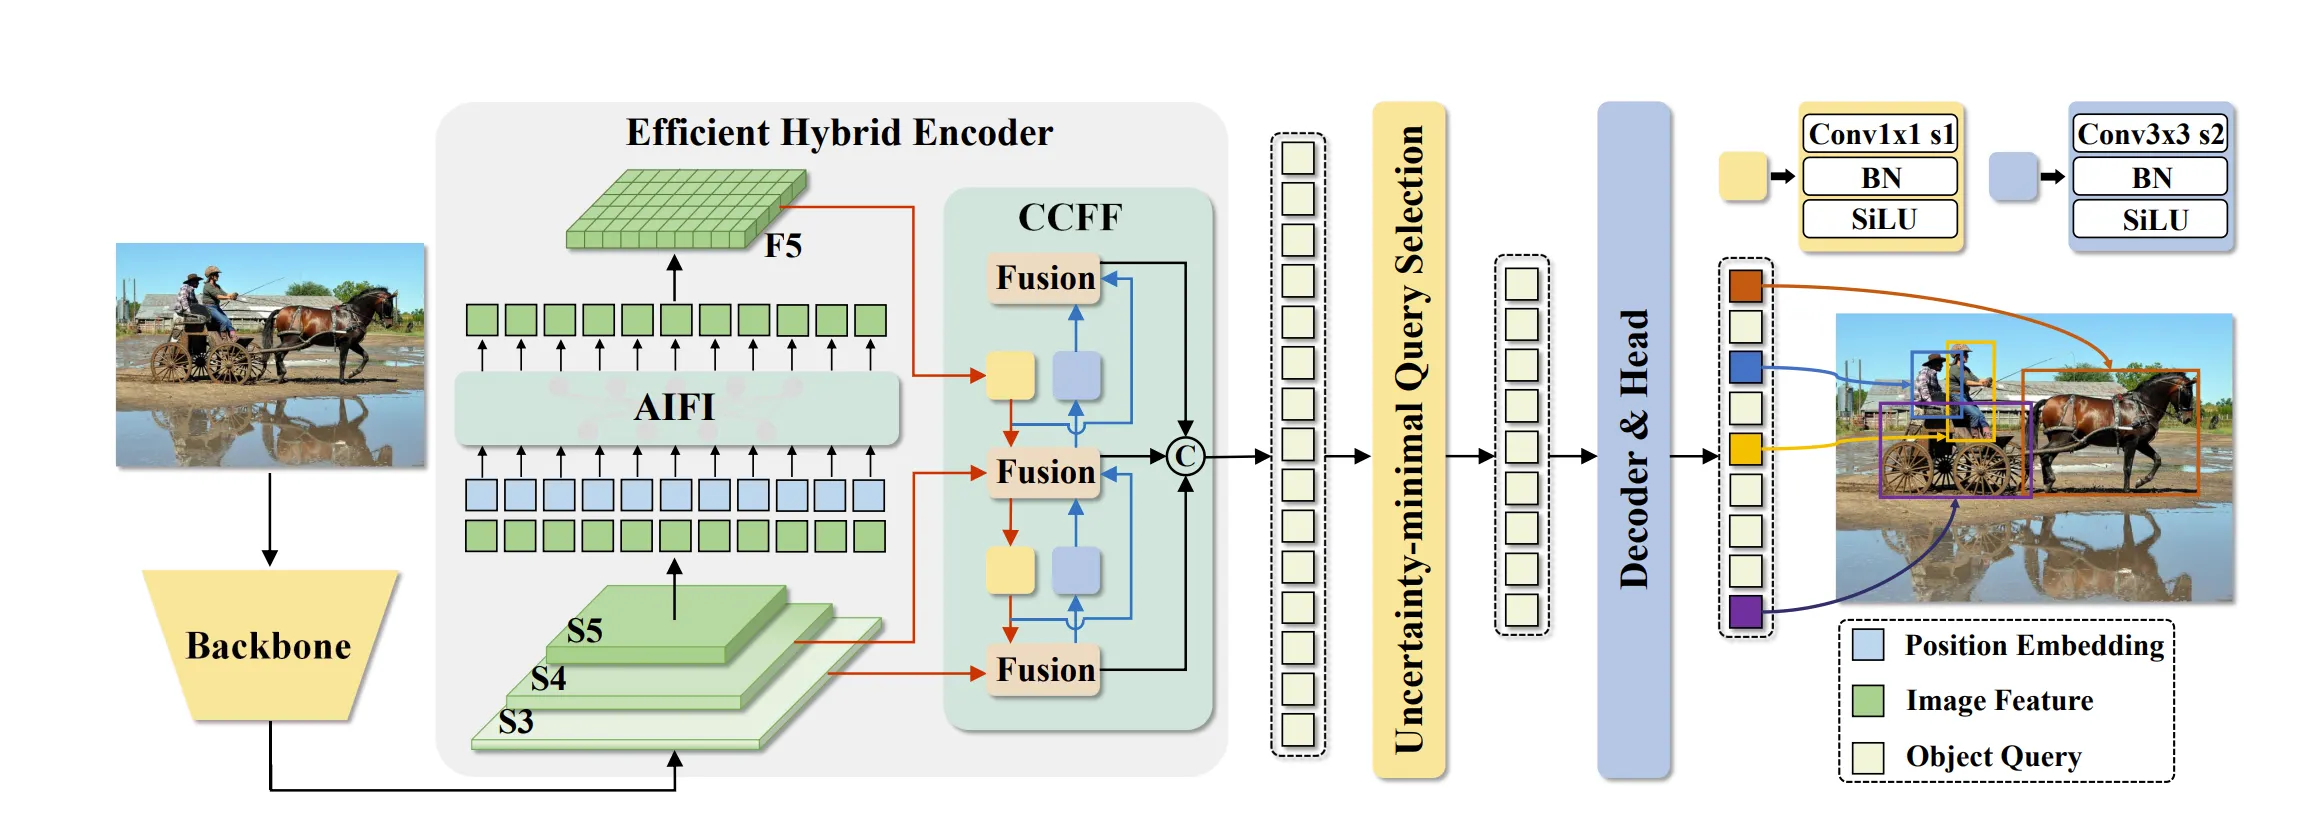

RT-DETR is the first **real-time, end-to-end object detector** based on Transformers. Unlike YOLO-style detectors, it **removes Non-Maximum Suppression (NMS)** and directly predicts a fixed set of objects in one forward pass.

### Key Ideas
- **Hybrid Encoder:** Efficient multi-scale feature fusion with lower computational cost than standard Transformers.
- **Uncertainty-Minimal Query Selection:** Selects high-confidence features to initialize object queries, improving localization and detection of small or dense objects.
- **End-to-End Detection:** No anchors and no NMS, leading to simpler and more stable inference.

### Highlights
- Strong performance in crowded scenes
- Better global context modeling than CNN-only detectors
- Real-time capable on GPUs (slower on CPU/MPS)

RT-DETR bridges the gap between DETR accuracy and YOLO speed by combining efficient Transformer design with end-to-end detection.




# import libraries

In [5]:
import os
import yaml
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from dl4cv_oda import (clean_osm_data, clip_labels_to_tiles, convert_to_yolo_format,
                       create_train_val_split, create_yolo_config, download_tiles)
from ultralytics import YOLO, RTDETR

## Configuration

In [6]:
DATA_DIR = Path("../data")
RAW_DIR = DATA_DIR / "raw"
CHIPS_DIR = DATA_DIR / "chips"
LABELS_DIR = DATA_DIR / "labels"
YOLO_DIR = DATA_DIR / "yolo"

OSM_FILE = RAW_DIR / "kolovai-trees.geojson"
CLEANED_FILE = RAW_DIR / "cleaned.geojson"
TREES_BOX_FILE = DATA_DIR / "trees_box.geojson"
TILES_FILE = DATA_DIR / "tiles.geojson"

IMG_SIZE = 256
EPOCHS = 200
PATIENCE = 10

TUNE_EPOCHS = 50
TUNE_ITERATIONS = 20
GPU_PER_TRIAL = 1

MODELS_TO_TRAIN = {
    "yolov8l": "yolov8l.pt",
    "yolo12l": "yolo12l.pt",
    "rtdetr-l": "rtdetr-l.pt"
}

In [7]:
import requests
if not OSM_FILE.exists():
    OSM_FILE.parent.mkdir(parents=True, exist_ok=True)
    OSM_FILE.write_bytes(requests.get("https://github.com/kshitijrajsharma/dl4cv-oda/blob/master/data/raw/kolovai-trees.geojson?raw=true", allow_redirects=True).content)
    print(f"Downloaded {OSM_FILE}")
else:
    print("OSM data ready")

OSM data ready


## Step 1: Clean OSM Data

In [8]:
if not CLEANED_FILE.exists():
    count = clean_osm_data(str(OSM_FILE), str(CLEANED_FILE), str(TREES_BOX_FILE))
    print(f"Processed {count} trees")
else:
    print("Cleaned data ready")

Cleaned data ready


## Download Tiles

In [9]:
if not TILES_FILE.exists():
    data = gpd.read_file(TREES_BOX_FILE)
    data.to_crs(epsg=4326, inplace=True)
    bbox = list(data.total_bounds)
    await download_tiles(bbox, 19, "https://tiles.openaerialmap.org/5a28639331eff4000c380690/0/5b1b6fb2-5024-4681-a175-9b667174f48c/{z}/{x}/{y}.png", DATA_DIR, 'OAM')
    print("Tiles downloaded")

## Clip Labels & Convert to YOLO Format

In [10]:
if TILES_FILE.exists() and not (YOLO_DIR / "train").exists():
    stats = clip_labels_to_tiles(str(TREES_BOX_FILE), str(TILES_FILE), str(LABELS_DIR))
    print(f"{stats['processed']} tiles, {stats['total_trees']} trees")
    class_mapping = convert_to_yolo_format(str(TREES_BOX_FILE), str(CHIPS_DIR), str(LABELS_DIR), str(YOLO_DIR), target_species="Coconut")
    print(f"Class mapping: {class_mapping}")
else:
    print("YOLO format data ready")

YOLO format data ready


## Create Train/Val/Test Split

In [11]:
if not (YOLO_DIR / "train").exists():
    train_count, val_count, test_count = create_train_val_split(str(LABELS_DIR), str(CHIPS_DIR), str(YOLO_DIR), train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)
    print(f"Train: {train_count} | Val: {val_count} | Test: {test_count}")
else:
    print("Train/Val/Test split ready")

config_file = create_yolo_config(str(YOLO_DIR), {"Coconut": 0})
config_file_abs = os.path.abspath(config_file)
print(f"Config: {config_file_abs}")

Train/Val/Test split ready
Config: /data/yolo/config.yaml


In [12]:
import inspect
print(create_train_val_split)                   # shows current object
print(inspect.signature(create_train_val_split))# shows current function signature
print(inspect.getsource(create_train_val_split))# prints the code Python is using


<function create_train_val_split at 0x7e43ea8c85e0>
(labels_dir, chips_dir, yolo_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)
def create_train_val_split(
    labels_dir, chips_dir, yolo_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1
):
    labels_dir = Path(labels_dir)
    chips_dir = Path(chips_dir)
    yolo_dir = Path(yolo_dir)
    yolo_labels_dir = yolo_dir / "labels"

    train_dir = yolo_dir / "train"
    val_dir = yolo_dir / "val"
    test_dir = yolo_dir / "test"
    train_dir.mkdir(exist_ok=True)
    val_dir.mkdir(exist_ok=True)
    test_dir.mkdir(exist_ok=True)

    data = []
    for label_file in labels_dir.glob("*.geojson"):
        trees = gpd.read_file(label_file)
        if not trees.empty:
            dominant_species = trees["species_mapped"].value_counts().idxmax()
            data.append({"file": label_file.stem, "species": dominant_species})

    df = pd.DataFrame(data)
    train_df = df.groupby("species", group_keys=False).apply(
        lambda x: x.samp

## Hyperparameter Tuning with Ray Tune

Tune all models with consistent parameters.

In [ ]:
import os
os.environ["WANDB_MODE"] = "disabled"


tune_results = {}
for model_name, model_weights in MODELS_TO_TRAIN.items():
    print(f"Tuning {model_name}...")
    model = RTDETR(model_weights) if "rtdetr" in model_name.lower() else YOLO(model_weights)
    result_grid = model.tune(data=config_file_abs, epochs=TUNE_EPOCHS, imgsz=IMG_SIZE,
                            patience=PATIENCE, iterations=TUNE_ITERATIONS,
                            gpu_per_trial=GPU_PER_TRIAL, use_ray=True)
    tune_results[model_name] = result_grid
    print(f"{model_name} tuning complete")

Tuning yolov8l...
💡 Learn about RayTune at https://docs.ultralytics.com/integrations/ray-tune
WARNING ⚠️ Search space not provided, using default search space.
+----------------------------------------------------------+
| Configuration for experiment     tune3                   |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        AsyncHyperBandScheduler |
| Number of trials                 20                      |
+----------------------------------------------------------+

View detailed results here: /content/runs/detect/tune3
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2026-01-11_00-44-03_325312_8144/artifacts/2026-01-11_00-46-02/tune3/driver_artifacts`

Trial status: 20 PENDING
Current time: 2026-01-11 00:46:02. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------

(_WandbLoggingActor pid=9285) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.


(_tune pid=9203) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=9203) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.7385452759033947, box=0.13103829855412807, cache=False, cfg=None, classes=None, close_mosaic=10, cls=3.4393847019123838, compile=False, conf=None, copy_paste=0.3668580885233387, copy_paste_mode=flip, cos_lr=False, cutmix=0.32550109568251573, data=/data/yolo/config.yaml, degrees=39.672589558592165, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.9577045873291952, flipud=0.7008638230998084, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.08463579739496865, hsv_s=0.5106148643859951, hsv_v=0.42874656210835355, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0727071317485165, lrf=0.9229816457616628, mask_ratio=4, max_det=300, mixup=0.239

2026-01-11 00:46:20,904	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=9285, ip=172.28.0.12, actor_id=bf7482a054212a605b3c687901000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7a9777521730>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/d

(_tune pid=9203) AMP: checks passed ✅
(_tune pid=9203) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2547.7±452.1 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train... 171 images, 0 backgrounds, 0 corrupt: 53% ━━━━━━────── 171/320 511.7it/s 0.1s<0.3s
train: Scanning /data/yolo/train... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 1.7Kit/s 0.2s
(_tune pid=9203) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=9203) train: New cache created: /data/yolo/train.cache
(_tune pid=9203) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=9203) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1195.8±677.0 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 1.4Kit/s 0.1s
(_tune pid=9203) val: /data

(_tune pid=9203) [2026-01-11 00:46:38,172 E 9203 9270] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 00:46:42,789	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.934 s, which may be a performance bottleneck.
2026-01-11 00:46:42,791	WARNING util.py:201 -- The `process_trial_result` operation took 1.936 s, which may be a performance bottleneck.
2026-01-11 00:46:42,793	WARNING util.py:201 -- Processing trial results took 1.938 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 00:46:42,794	WARNING util.py:201 -- The `process_trial_result` operation took 1.938 s, which may be a performance bottleneck.


(_tune pid=9203) 
(_tune pid=9203)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.66G    0.06338      15.87      1.643        322        256: 0% ──────────── 0/20  0.3s
       2/50      2.66G    0.06168       15.8      1.655        564        256: 5% ╸─────────── 1/20 1.4it/s 0.5s<13.2s
       2/50      2.67G    0.06109      15.65        1.7        446        256: 10% ━─────────── 2/20 1.9it/s 0.9s<9.7s
       2/50      2.67G    0.06117      15.48      1.737        503        256: 15% ━╸────────── 3/20 2.4it/s 1.2s<7.0s
       2/50      2.67G     0.0617      15.02      1.718        639        256: 20% ━━────────── 4/20 2.7it/s 1.5s<6.0s
       2/50      2.67G    0.06096      14.77      1.704        507        256: 25% ━━━───────── 5/20 3.5it/s 1.7s<4.3s
       2/50      2.67G    0.06103      14.53      1.693        733        256: 30% ━━━╸──────── 6/20 3.7it/s 1.9s<3.8s
       2/50      2.67G    0.05983      14.32      1.674        488 

(_WandbLoggingActor pid=10550) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_QueueActor pid=9286) [2026-01-11 00:46:42,051 E 9286 9321] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(_tune pid=10496) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=10496) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.7316860891364567, box=0.1313539973700017, cache=False, cfg=None, classes=None, close_mosaic=10, cls=3.762679127647857, compile=False, conf=None, copy_paste=0.018220930575440386, copy_paste_mode=flip, cos_lr=False, cutmix=0.8314669507920143, data=/data/yolo/config.yaml, degrees=31.684628389093906, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.6577773515834073, flipud=0.6765617460244313, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.07687496156636314, hsv_s=0.297044410086176, hsv_v=0.13527399904412205, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.015521679234016738, lrf=0.5834075475439323, mask_ratio=4, max_det=300, mixup=0.4

2026-01-11 00:50:42,211	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=10550, ip=172.28.0.12, actor_id=a787ceaddfd570b9c4af280c01000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x78283820bc50>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=10496) AMP: checks passed ✅
(_tune pid=10496) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2809.7±696.3 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 44.7Mit/s 0.0s
(_tune pid=10496) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=10496) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=10496) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1888.3±1475.4 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 7.2Mit/s 0.0s
(_tune pid=10496) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=10496) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=1049

(_tune pid=10496) [2026-01-11 00:50:57,868 E 10496 10533] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 00:51:00,616	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.075 s, which may be a performance bottleneck.
2026-01-11 00:51:00,617	WARNING util.py:201 -- The `process_trial_result` operation took 2.077 s, which may be a performance bottleneck.
2026-01-11 00:51:00,618	WARNING util.py:201 -- Processing trial results took 2.077 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 00:51:00,619	WARNING util.py:201 -- The `process_trial_result` operation took 2.079 s, which may be a performance bottleneck.


(_tune pid=10496) 
(_tune pid=10496)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.58G    0.07377      17.72       1.93        864        256: 0% ──────────── 0/20  0.3s
       2/50      2.58G    0.06773      16.81      1.867        643        256: 5% ╸─────────── 1/20 1.7it/s 0.4s<11.0s
       2/50      2.65G     0.0689      16.69       1.88        700        256: 10% ━─────────── 2/20 2.7it/s 0.7s<6.8s
       2/50      2.65G    0.06792       16.3      1.871        877        256: 15% ━╸────────── 3/20 3.8it/s 0.8s<4.5s
       2/50      2.65G    0.06789      16.14      1.877        968        256: 20% ━━────────── 4/20 3.6it/s 1.1s<4.5s
       2/50      2.65G    0.06863      16.12      1.876        821        256: 25% ━━━───────── 5/20 4.4it/s 1.3s<3.4s
       2/50      2.65G    0.06775      16.74      1.868        713        256: 30% ━━━╸──────── 6/20 4.1it/s 1.6s<3.4s
       2/50      2.65G    0.06833      16.61       1.87        71

(_QueueActor pid=10549) [2026-01-11 00:51:03,687 E 10549 10592] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


       2/50      2.65G    0.06681      16.26      1.832       1036        256: 70% ━━━━━━━━──── 14/20 4.6it/s 3.2s<1.3s
       2/50      2.65G    0.06722      16.21      1.821        718        256: 75% ━━━━━━━━━─── 15/20 5.2it/s 3.4s<1.0s
       2/50      2.65G    0.06685      16.12      1.813        672        256: 80% ━━━━━━━━━╸── 16/20 4.7it/s 3.6s<0.8s
       2/50      2.65G     0.0662      16.08      1.801        813        256: 85% ━━━━━━━━━━── 17/20 5.0it/s 3.8s<0.6s
       2/50      2.65G    0.06622      16.03      1.792        963        256: 90% ━━━━━━━━━━╸─ 18/20 4.8it/s 4.1s<0.4s
       2/50      2.65G    0.06587      16.01      1.787        766        256: 100% ━━━━━━━━━━━━ 20/20 4.7it/s 4.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 33% ━━━━──────── 1/3 1.7it/s 0.2s<1.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 67% ━━━━━━━━──── 2/3 2.4it/s 0.4s<0.4s
                 Class    

(_WandbLoggingActor pid=12070) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_WandbLoggingActor pid=10550) [2026-01-11 00:51:03,713 E 10550 10615] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(_tune pid=12012) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=12012) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.8059710652297701, box=0.06445431479551766, cache=False, cfg=None, classes=None, close_mosaic=10, cls=2.311384482856284, compile=False, conf=None, copy_paste=0.3559919996584163, copy_paste_mode=flip, cos_lr=False, cutmix=0.5782532350192203, data=/data/yolo/config.yaml, degrees=25.634051407299946, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.8715088549069774, flipud=0.6473187975115506, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.06338576922577119, hsv_s=0.8472564742815882, hsv_v=0.5218904750541603, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0657648459206258, lrf=0.7304972380878582, mask_ratio=4, max_det=300, mixup=0.5465

2026-01-11 00:56:02,556	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=12070, ip=172.28.0.12, actor_id=c45fbc77985209c0100b097e01000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7fa26d163ec0>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/


Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2026-01-11 00:56:03. Total running time: 10min 1s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name          status               lr0         lrf     momentum     weight_decay     warmup_epochs     warmup_momentum         box        cls         hsv_h       hsv_s       hsv_v     degrees     translate       scale      shear     perspective     flipud      fliplr        bgr      mosaic       mixup      cutmix     copy_paste     iter

(_tune pid=12012) [2026-01-11 00:56:19,631 E 12012 12055] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2026-01-11 00:56:44. Total running time: 10min 41s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name          status               lr0         lrf     momentum     weight_decay     warmup_epochs     warmup_momentum         box        cls         hsv_h       hsv_s       hsv_v     degrees     translate       scale      shear     perspective     flipud      fliplr        bgr      mosaic       mixup      cutmix     copy_paste     iter

2026-01-11 00:56:52,730	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.417 s, which may be a performance bottleneck.
2026-01-11 00:56:52,731	WARNING util.py:201 -- The `process_trial_result` operation took 1.418 s, which may be a performance bottleneck.
2026-01-11 00:56:52,733	WARNING util.py:201 -- Processing trial results took 1.420 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 00:56:52,735	WARNING util.py:201 -- The `process_trial_result` operation took 1.422 s, which may be a performance bottleneck.


(_tune pid=12012) 
(_tune pid=12012)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.57G    0.02375      9.006       1.35        227        256: 0% ──────────── 0/20  0.3s
       2/50      2.57G    0.02333      13.56      1.341        248        256: 5% ╸─────────── 1/20 1.8it/s 0.4s<10.7s
       2/50      2.57G    0.02309      18.99       1.34        160        256: 10% ━─────────── 2/20 2.7it/s 0.6s<6.7s
       2/50      2.57G    0.02256      19.56      1.315        218        256: 15% ━╸────────── 3/20 3.6it/s 0.8s<4.8s
       2/50      2.57G    0.02277      18.34      1.334        278        256: 20% ━━────────── 4/20 3.8it/s 1.1s<4.2s
       2/50      2.57G    0.02273      16.69       1.34        261        256: 25% ━━━───────── 5/20 4.5it/s 1.2s<3.3s
       2/50      2.57G    0.02263      15.84      1.342        207        256: 30% ━━━╸──────── 6/20 4.5it/s 1.4s<3.1s
       2/50      2.57G     0.0226      15.01      1.335        21

(_WandbLoggingActor pid=12976) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_QueueActor pid=12072) [2026-01-11 00:56:23,698 E 12072 12108] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 2x across cluster]


(_tune pid=12918) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=12918) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.7237248590133404, box=0.02583553530992101, cache=False, cfg=None, classes=None, close_mosaic=10, cls=2.1160756766182973, compile=False, conf=None, copy_paste=0.6781391466782247, copy_paste_mode=flip, cos_lr=False, cutmix=0.6140941521818225, data=/data/yolo/config.yaml, degrees=26.649566666700302, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.7902431215659914, flipud=0.4676903350642976, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.04557477799899842, hsv_s=0.43469192312402405, hsv_v=0.3721663625832911, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.03821668372789818, lrf=0.6817057664142009, mask_ratio=4, max_det=300, mixup=0.6

2026-01-11 00:59:10,726	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=12976, ip=172.28.0.12, actor_id=173343af22364d6ee336c80001000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x788ae1fd8920>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=12918) AMP: checks passed ✅
(_tune pid=12918) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2779.2±653.6 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 79.0Mit/s 0.0s
(_tune pid=12918) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=12918) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=12918) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1760.8±1419.6 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 8.0Mit/s 0.0s
(_tune pid=12918) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=12918) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=1291

(_tune pid=12918) [2026-01-11 00:59:27,488 E 12918 12958] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(_WandbLoggingActor pid=12976) [2026-01-11 00:59:31,723 E 12976 13034] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 00:59:37,401	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.420 s, which may be a performance bottleneck.
2026-01-11 00:59:37,403	WARNING util.py:201 -- The `process_trial_result` operation took 1.422 s, which may be a performance bottleneck.
2026-01-11 00:59:37,405	WARNING util.py:201 -- Processing trial results took 1.424 s, which may be a performance bottleneck. Please consider reporti

(_tune pid=12918) 
(_tune pid=12918)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.58G    0.01197      9.352        1.8        551        256: 0% ──────────── 0/20  0.3s
       2/50      2.58G    0.01116      8.748      1.663        408        256: 5% ╸─────────── 1/20 1.8it/s 0.4s<10.6s
       2/50      2.58G     0.0111      8.588      1.621        527        256: 10% ━─────────── 2/20 2.6it/s 0.7s<6.9s
       2/50      2.58G    0.01125      8.563      1.623        639        256: 15% ━╸────────── 3/20 3.6it/s 0.8s<4.8s
       2/50      2.58G    0.01116      8.433      1.612        588        256: 20% ━━────────── 4/20 3.5it/s 1.1s<4.6s
       2/50      2.58G    0.01117      8.398      1.598        447        256: 25% ━━━───────── 5/20 4.0it/s 1.3s<3.7s
       2/50      2.58G     0.0111      8.336      1.591        467        256: 30% ━━━╸──────── 6/20 3.9it/s 1.6s<3.6s
       2/50      2.58G    0.01107      8.216      1.575        53

(_WandbLoggingActor pid=14216) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_QueueActor pid=12975) [2026-01-11 00:59:31,458 E 12975 13008] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(_tune pid=14155) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=14155) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.9571193030092193, box=0.14892861398951718, cache=False, cfg=None, classes=None, close_mosaic=10, cls=3.4357393554163815, compile=False, conf=None, copy_paste=0.005029149235481145, copy_paste_mode=flip, cos_lr=False, cutmix=0.07783172521319859, data=/data/yolo/config.yaml, degrees=0.7689412041874882, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.28007922611040725, flipud=0.21930914637188303, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.062201523836389244, hsv_s=0.1510149997393709, hsv_v=0.8624436786130719, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.04741762214610309, lrf=0.1419192364210531, mask_ratio=4, max_det=300, mixu

2026-01-11 01:03:40,984	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=14216, ip=172.28.0.12, actor_id=6ab1ecfa6a2b38f44349cd8301000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7a879fb3f7a0>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=14155) AMP: checks passed ✅
(_tune pid=14155) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2837.7±817.3 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 58.4Mit/s 0.0s
(_tune pid=14155) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=14155) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=14155) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1507.1±1472.6 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 4.4Mit/s 0.0s
(_tune pid=14155) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=14155) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=1415

(_tune pid=14155) [2026-01-11 01:03:57,628 E 14155 14193] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Trial status: 4 TERMINATED | 1 RUNNING | 15 PENDING
Current time: 2026-01-11 01:04:26. Total running time: 18min 24s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name          status               lr0         lrf     momentum     weight_decay     warmup_epochs     warmup_momentum         box        cls         hsv_h       hsv_s       hsv_v     degrees     translate       scale      shear     perspective     flipud      fliplr        bgr      mosaic       mixup      cutmix     copy_paste     iter

2026-01-11 01:04:29,511	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.367 s, which may be a performance bottleneck.
2026-01-11 01:04:29,513	WARNING util.py:201 -- The `process_trial_result` operation took 1.369 s, which may be a performance bottleneck.
2026-01-11 01:04:29,514	WARNING util.py:201 -- Processing trial results took 1.370 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:04:29,516	WARNING util.py:201 -- The `process_trial_result` operation took 1.372 s, which may be a performance bottleneck.


(_tune pid=14155) 
(_tune pid=14155)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.58G     0.0704      16.77       1.76        284        256: 0% ──────────── 0/20  0.3s
       2/50      2.58G     0.0662      15.99      1.744        243        256: 5% ╸─────────── 1/20 1.8it/s 0.4s<10.8s
       2/50      2.58G    0.06897       15.4      1.722        352        256: 10% ━─────────── 2/20 2.5it/s 0.7s<7.1s
       2/50      2.58G    0.06957      15.68      1.723        302        256: 15% ━╸────────── 3/20 2.1it/s 1.5s<7.9s
       2/50      2.58G    0.06964      15.91       1.74        232        256: 20% ━━────────── 4/20 2.7it/s 1.7s<5.9s
       2/50      2.58G    0.06981      15.89      1.756        355        256: 25% ━━━───────── 5/20 3.7it/s 1.9s<4.0s
       2/50      2.58G    0.06939      15.85      1.748        195        256: 30% ━━━╸──────── 6/20 4.0it/s 2.1s<3.5s
       2/50      2.58G    0.06864      15.95      1.746        25

2026-01-11 01:05:11,575	WARNING util.py:201 -- The `on_step_begin` operation took 4.580 s, which may be a performance bottleneck.


(_tune pid=14155) 
(_tune pid=14155)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      2.76G    0.05483      13.74       1.38        292        256: 0% ──────────── 0/20  0.3s
       3/50      2.76G     0.0565      13.51      1.407        232        256: 5% ╸─────────── 1/20 2.0it/s 0.5s<9.7s
       3/50      2.76G     0.0586       13.7      1.408        266        256: 10% ━─────────── 2/20 2.1it/s 0.9s<8.7s
       3/50      2.76G    0.05765       13.6      1.404        178        256: 15% ━╸────────── 3/20 3.1it/s 1.1s<5.6s
       3/50      2.76G    0.06007      13.72      1.428        297        256: 20% ━━────────── 4/20 2.9it/s 1.5s<5.4s
       3/50      2.76G     0.0589       13.4       1.42        267        256: 25% ━━━───────── 5/20 3.3it/s 1.7s<4.6s
       3/50      2.76G    0.05846      13.28      1.416        185        256: 30% ━━━╸──────── 6/20 3.1it/s 2.1s<4.4s
       3/50      2.76G    0.05888      13.26      1.428        294

(_WandbLoggingActor pid=15217) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_WandbLoggingActor pid=14216) [2026-01-11 01:04:01,732 E 14216 14274] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 2x across cluster]


(_tune pid=15163) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=15163) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.17766224997760827, box=0.03178670107265692, cache=False, cfg=None, classes=None, close_mosaic=10, cls=2.634777701593184, compile=False, conf=None, copy_paste=0.7959607024411578, copy_paste_mode=flip, cos_lr=False, cutmix=0.26314105179109815, data=/data/yolo/config.yaml, degrees=27.201300577726165, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.7829524442507507, flipud=0.8259880308667903, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.07939526386217714, hsv_s=0.3141544171222073, hsv_v=0.17025450828703184, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0662213167899144, lrf=0.5163887608544103, mask_ratio=4, max_det=300, mixup=0.9

2026-01-11 01:07:15,166	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=15217, ip=172.28.0.12, actor_id=98653b6b6974e8941d95377601000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7ee1829dbb60>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=15163) AMP: checks passed ✅
(_tune pid=15163) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3360.5±1113.4 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 55.9Mit/s 0.0s
(_tune pid=15163) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=15163) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=15163) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1736.8±1602.6 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 5.4Mit/s 0.0s
(_tune pid=15163) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=15163) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=151

(_tune pid=15163) [2026-01-11 01:07:31,045 E 15163 15199] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(_QueueActor pid=15219) [2026-01-11 01:07:35,869 E 15219 15254] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Trial status: 5 TERMINATED | 1 RUNNING | 14 PENDING
Current time: 2026-01-11 01:07:57. Total running time: 21min 54s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name          status               lr0         lrf     momentum     weight_decay     warmup_epochs     warmup_momentum         box        cls         hsv_h       hsv_s       hsv_v     degrees     translate       scale      shear     perspective     flipud      fliplr        bgr      mosaic       mixup      cutmix     copy_paste     iter

2026-01-11 01:07:59,982	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.388 s, which may be a performance bottleneck.
2026-01-11 01:07:59,984	WARNING util.py:201 -- The `process_trial_result` operation took 1.390 s, which may be a performance bottleneck.
2026-01-11 01:07:59,987	WARNING util.py:201 -- Processing trial results took 1.393 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:07:59,987	WARNING util.py:201 -- The `process_trial_result` operation took 1.393 s, which may be a performance bottleneck.


(_tune pid=15163) 
(_tune pid=15163)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.67G     0.0148      10.67      1.754        766        256: 0% ──────────── 0/20  0.3s
       2/50      2.67G    0.01471      10.48      1.712        763        256: 5% ╸─────────── 1/20 1.9it/s 0.5s<10.2s
       2/50      2.67G    0.01495       10.3      1.689        980        256: 10% ━─────────── 2/20 2.5it/s 0.7s<7.2s
       2/50      2.67G    0.01461      10.22      1.673        727        256: 15% ━╸────────── 3/20 3.3it/s 0.9s<5.2s
       2/50      2.67G    0.01471      10.28      1.685        860        256: 20% ━━────────── 4/20 3.5it/s 1.2s<4.6s
       2/50      2.67G    0.01479      10.22      1.698        922        256: 25% ━━━───────── 5/20 4.0it/s 1.4s<3.8s
       2/50      2.67G    0.01481      10.16      1.688        773        256: 30% ━━━╸──────── 6/20 4.1it/s 1.6s<3.4s
       2/50      2.67G    0.01458      10.09      1.672        68

2026-01-11 01:10:15,843	WARNING util.py:201 -- The `on_step_begin` operation took 2.570 s, which may be a performance bottleneck.


(_tune pid=15163) 
(_tune pid=15163)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      3.97G    0.01082      7.201      1.291        937        256: 0% ──────────── 0/20  0.2s
      11/50      4.07G    0.01089      7.334      1.302        740        256: 5% ╸─────────── 1/20 1.5it/s 0.4s<12.8s
      11/50      4.07G    0.01095       7.37      1.344        637        256: 10% ━─────────── 2/20 2.7it/s 0.6s<6.6s
      11/50      4.07G    0.01119      7.719      1.348        679        256: 15% ━╸────────── 3/20 3.0it/s 0.9s<5.6s
      11/50      4.07G    0.01112      7.583      1.354        909        256: 20% ━━────────── 4/20 3.9it/s 1.0s<4.1s
      11/50      4.13G    0.01113      7.548      1.351        849        256: 25% ━━━───────── 5/20 4.3it/s 1.2s<3.5s
      11/50      4.13G    0.01112      7.526      1.347        766        256: 30% ━━━╸──────── 6/20 4.5it/s 1.4s<3.1s
      11/50      4.13G     0.0113      7.564      1.353        92

(_tune pid=15163) 
(_tune pid=15163)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      4.19G     0.0104      7.752      1.354        598        256: 0% ──────────── 0/20  0.2s
      15/50      4.19G    0.01068      8.038      1.375        564        256: 5% ╸─────────── 1/20 1.4it/s 0.4s<13.1s
      15/50      4.19G    0.01089      8.037      1.364        973        256: 10% ━─────────── 2/20 2.6it/s 0.6s<6.8s
      15/50      4.19G    0.01083      7.991      1.365        771        256: 15% ━╸────────── 3/20 2.9it/s 0.9s<5.8s
      15/50      4.19G    0.01095      8.079      1.357        740        256: 20% ━━────────── 4/20 3.7it/s 1.1s<4.3s
      15/50      4.19G    0.01111      8.085      1.351        989        256: 25% ━━━───────── 5/20 3.8it/s 1.3s<3.9s
      15/50      4.19G    0.01108      8.011      1.342        891        256: 30% ━━━╸──────── 6/20 4.2it/s 1.5s<3.3s
      15/50      4.19G    0.01109      8.016      1.343        71

(_WandbLoggingActor pid=17497) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_WandbLoggingActor pid=15217) [2026-01-11 01:07:36,114 E 15217 15281] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(_tune pid=17439) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=17439) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.649656241237589, box=0.11435165144460542, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.8598940563080573, compile=False, conf=None, copy_paste=0.22963526206399676, copy_paste_mode=flip, cos_lr=False, cutmix=0.5482155967343201, data=/data/yolo/config.yaml, degrees=44.05036190321092, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.7873514939453365, flipud=0.25136297977285327, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.007652543996725315, hsv_s=0.7848687112974673, hsv_v=0.33290938372066803, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01977862679588094, lrf=0.7748857317167841, mask_ratio=4, max_det=300, mixup=0.

2026-01-11 01:16:00,959	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=17497, ip=172.28.0.12, actor_id=f39b92b4a19a240e8c3fca3701000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7a96f85c2ab0>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=17439) AMP: checks passed ✅
(_tune pid=17439) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2302.7±667.6 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 63.9Mit/s 0.0s
(_tune pid=17439) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=17439) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=17439) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1558.5±1216.9 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 5.7Mit/s 0.0s
(_tune pid=17439) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=17439) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=1743

(_tune pid=17439) [2026-01-11 01:16:18,688 E 17439 17481] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


Trial status: 6 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2026-01-11 01:16:20. Total running time: 30min 18s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name          status               lr0         lrf     momentum     weight_decay     warmup_epochs     warmup_momentum         box        cls         hsv_h       hsv_s       hsv_v     degrees     translate       scale      shear     perspective     flipud      fliplr        bgr      mosaic       mixup      cutmix     copy_paste     iter

2026-01-11 01:16:52,446	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.420 s, which may be a performance bottleneck.
2026-01-11 01:16:52,448	WARNING util.py:201 -- The `process_trial_result` operation took 1.422 s, which may be a performance bottleneck.
2026-01-11 01:16:52,450	WARNING util.py:201 -- Processing trial results took 1.424 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:16:52,452	WARNING util.py:201 -- The `process_trial_result` operation took 1.426 s, which may be a performance bottleneck.


(_tune pid=17439) 
(_tune pid=17439)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.55G    0.04137      3.231      1.464        214        256: 0% ──────────── 0/20  0.3s
       2/50      2.55G    0.04064      3.694      1.516        182        256: 5% ╸─────────── 1/20 1.8it/s 0.4s<10.3s
       2/50      2.55G    0.04231      3.854      1.549        258        256: 10% ━─────────── 2/20 2.5it/s 0.7s<7.1s
       2/50      2.55G    0.04285      3.818      1.564        209        256: 15% ━╸────────── 3/20 3.6it/s 0.8s<4.7s
       2/50      2.55G    0.04268      3.794      1.544        281        256: 20% ━━────────── 4/20 3.9it/s 1.1s<4.1s
       2/50      2.55G    0.04272      3.647      1.536        256        256: 25% ━━━───────── 5/20 4.4it/s 1.2s<3.4s
       2/50      2.55G    0.04288      3.541       1.53        198        256: 30% ━━━╸──────── 6/20 4.6it/s 1.4s<3.1s
       2/50      2.55G    0.04307      3.474      1.536        26

(_tune pid=17439) 
(_tune pid=17439)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      4.04G    0.03808      2.431      1.343        246        256: 0% ──────────── 0/20  0.2s
      13/50      4.04G    0.03845      2.542      1.333        163        256: 5% ╸─────────── 1/20 1.4it/s 0.4s<13.2s
      13/50      4.04G    0.03868      2.638       1.32        189        256: 10% ━─────────── 2/20 2.9it/s 0.6s<6.1s
      13/50      4.04G    0.03931      2.651      1.356        262        256: 15% ━╸────────── 3/20 3.4it/s 0.8s<5.0s
      13/50      4.04G    0.03925      2.755      1.381        115        256: 20% ━━────────── 4/20 4.2it/s 1.0s<3.8s
      13/50      4.04G    0.03844      2.716      1.368        328        256: 25% ━━━───────── 5/20 4.6it/s 1.1s<3.3s
      13/50      4.04G    0.03844      2.702      1.354        137        256: 30% ━━━╸──────── 6/20 5.0it/s 1.3s<2.8s
      13/50      4.04G    0.03825      2.681      1.359        26

(_WandbLoggingActor pid=18900) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_WandbLoggingActor pid=17497) [2026-01-11 01:16:22,917 E 17497 17555] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 2x across cluster]


(_tune pid=18844) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=18844) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.9794585825411566, box=0.023331243214090108, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0927219062900186, compile=False, conf=None, copy_paste=0.9839914564837358, copy_paste_mode=flip, cos_lr=False, cutmix=0.34082561966938274, data=/data/yolo/config.yaml, degrees=19.030617271424344, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.07729323889454243, flipud=0.9058747522880977, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.08189019434491646, hsv_s=0.5722276167029274, hsv_v=0.03799251500387984, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.03583900392325607, lrf=0.7271047205590673, mask_ratio=4, max_det=300, mixup=

2026-01-11 01:21:14,263	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=18900, ip=172.28.0.12, actor_id=24e24f0a3545c73f05df5e8f01000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7acba4ae8aa0>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=18844) AMP: checks passed ✅
(_tune pid=18844) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3462.9±918.4 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 63.9Mit/s 0.0s
(_tune pid=18844) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=18844) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=18844) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1523.6±1429.1 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 5.7Mit/s 0.0s
(_tune pid=18844) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=18844) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=1884

(_tune pid=18844) [2026-01-11 01:21:30,426 E 18844 18884] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 01:21:34,125	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.407 s, which may be a performance bottleneck.
2026-01-11 01:21:34,126	WARNING util.py:201 -- The `process_trial_result` operation took 1.408 s, which may be a performance bottleneck.
2026-01-11 01:21:34,127	WARNING util.py:201 -- Processing trial results took 1.408 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:21:34,129	WARNING util.py:201 -- The `process_trial_result` operation took 1.410 s, which may be a performance bottleneck.


(_tune pid=18844) 
(_tune pid=18844)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.59G   0.008876      3.833      1.411        653        256: 0% ──────────── 0/20  0.3s
       2/50      2.59G   0.008732       4.14      1.375        381        256: 5% ╸─────────── 1/20 1.8it/s 0.5s<10.4s
       2/50      2.59G   0.008642      4.218      1.362        393        256: 10% ━─────────── 2/20 2.6it/s 0.7s<6.9s
       2/50      2.59G   0.008641      4.052      1.354        592        256: 15% ━╸────────── 3/20 3.7it/s 0.8s<4.6s
       2/50      2.59G   0.008593      3.928      1.347        587        256: 20% ━━────────── 4/20 3.9it/s 1.1s<4.1s
       2/50      2.59G   0.008488      3.784       1.33        645        256: 25% ━━━───────── 5/20 4.5it/s 1.2s<3.3s
       2/50      2.59G   0.008331      3.741      1.314        402        256: 30% ━━━╸──────── 6/20 4.3it/s 1.5s<3.3s


(_QueueActor pid=18901) [2026-01-11 01:21:35,622 E 18901 18937] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


       2/50      2.59G   0.008322       3.71      1.308        522        256: 35% ━━━━──────── 7/20 4.6it/s 1.7s<2.8s
       2/50      2.59G   0.008323      3.699       1.31        735        256: 40% ━━━━╸─────── 8/20 4.6it/s 1.9s<2.6s
       2/50      2.59G   0.008276      3.699      1.307        413        256: 45% ━━━━━─────── 9/20 4.9it/s 2.1s<2.2s
       2/50      2.59G   0.008243      3.636      1.304        599        256: 50% ━━━━━━────── 10/20 4.5it/s 2.4s<2.2s
       2/50      2.59G   0.008199      3.597      1.298        604        256: 55% ━━━━━━╸───── 11/20 5.0it/s 2.5s<1.8s
       2/50      2.59G   0.008188      3.562        1.3        512        256: 60% ━━━━━━━───── 12/20 4.9it/s 2.8s<1.6s
       2/50      2.59G   0.008119      3.523      1.293        630        256: 65% ━━━━━━━╸──── 13/20 5.3it/s 2.9s<1.3s
       2/50      2.59G   0.008094      3.493       1.29        532        256: 70% ━━━━━━━━──── 14/20 4.8it/s 3.2s<1.2s
       2/50      2.59G   0.008049      3.49

2026-01-11 01:22:10,698	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 5.094 s, which may be a performance bottleneck.
2026-01-11 01:22:10,700	WARNING util.py:201 -- The `process_trial_result` operation took 5.097 s, which may be a performance bottleneck.
2026-01-11 01:22:10,702	WARNING util.py:201 -- Processing trial results took 5.098 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:22:10,703	WARNING util.py:201 -- The `process_trial_result` operation took 5.099 s, which may be a performance bottleneck.


(_tune pid=18844) 
(_tune pid=18844)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      3.06G   0.006642        2.6      1.126        616        256: 0% ──────────── 0/20  0.3s
       5/50      3.06G   0.006589      2.541      1.119        539        256: 5% ╸─────────── 1/20 1.7it/s 0.5s<11.4s
       5/50      3.06G   0.006752      2.584       1.13        584        256: 10% ━─────────── 2/20 2.6it/s 0.7s<7.0s
       5/50      3.06G   0.006634      2.624      1.127        499        256: 15% ━╸────────── 3/20 3.1it/s 0.9s<5.4s
       5/50      3.06G   0.006646      2.619      1.126        593        256: 20% ━━────────── 4/20 3.9it/s 1.1s<4.1s
       5/50      3.06G   0.006676      2.634       1.13        477        256: 25% ━━━───────── 5/20 4.3it/s 1.3s<3.5s
       5/50      3.06G   0.006709      2.661      1.133        468        256: 30% ━━━╸──────── 6/20 4.6it/s 1.5s<3.0s
       5/50      3.06G   0.006668      2.635      1.129        57

(_WandbLoggingActor pid=21170) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_WandbLoggingActor pid=18900) [2026-01-11 01:21:36,056 E 18900 18971] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14



Trial status: 8 TERMINATED | 1 RUNNING | 11 PENDING
Current time: 2026-01-11 01:29:52. Total running time: 43min 50s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name          status               lr0         lrf     momentum     weight_decay     warmup_epochs     warmup_momentum         box        cls         hsv_h       hsv_s       hsv_v     degrees     translate       scale      shear     perspective     flipud      fliplr        bgr      mosaic       mixup      cutmix     copy_paste     ite

2026-01-11 01:29:55,932	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=21170, ip=172.28.0.12, actor_id=87649700c21640769f6eac6d01000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7effad557830>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=21112) AMP: checks passed ✅
(_tune pid=21112) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3229.6±1141.1 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 58.4Mit/s 0.0s
(_tune pid=21112) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=21112) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=21112) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1404.8±1291.3 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 5.1Mit/s 0.0s
(_tune pid=21112) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=21112) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=211

(_tune pid=21112) [2026-01-11 01:30:13,039 E 21112 21154] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(_WandbLoggingActor pid=21170) [2026-01-11 01:30:17,310 E 21170 21230] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 2x across cluster]


Trial status: 8 TERMINATED | 1 RUNNING | 11 PENDING
Current time: 2026-01-11 01:30:37. Total running time: 44min 35s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name          status               lr0         lrf     momentum     weight_decay     warmup_epochs     warmup_momentum         box        cls         hsv_h       hsv_s       hsv_v     degrees     translate       scale      shear     perspective     flipud      fliplr        bgr      mosaic       mixup      cutmix     copy_paste     iter

2026-01-11 01:30:55,344	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.010 s, which may be a performance bottleneck.
2026-01-11 01:30:55,346	WARNING util.py:201 -- The `process_trial_result` operation took 2.012 s, which may be a performance bottleneck.
2026-01-11 01:30:55,349	WARNING util.py:201 -- Processing trial results took 2.015 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:30:55,351	WARNING util.py:201 -- The `process_trial_result` operation took 2.016 s, which may be a performance bottleneck.


(_tune pid=21112) 
(_tune pid=21112)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.58G    0.02915      7.907      1.438        512        256: 0% ──────────── 0/20  0.3s
       2/50      2.58G      0.029      6.609      1.454        527        256: 5% ╸─────────── 1/20 1.6it/s 0.5s<11.9s
       2/50      2.58G    0.02848      6.155      1.452        424        256: 10% ━─────────── 2/20 2.4it/s 0.7s<7.4s
       2/50      2.58G    0.02829      6.107      1.446        472        256: 15% ━╸────────── 3/20 3.3it/s 0.9s<5.2s
       2/50      2.58G    0.02838      6.148      1.451        572        256: 20% ━━────────── 4/20 3.5it/s 1.1s<4.6s
       2/50      2.58G    0.02848      6.036      1.447        697        256: 25% ━━━───────── 5/20 4.1it/s 1.3s<3.7s
       2/50      2.58G    0.02847       5.92      1.436        591        256: 30% ━━━╸──────── 6/20 4.2it/s 1.5s<3.3s
       2/50      2.58G    0.02821      5.812      1.426        49

(_tune pid=21112) 
(_tune pid=21112)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      3.32G    0.02436      4.769      1.255        410        256: 0% ──────────── 0/20  0.2s
       7/50      3.32G    0.02415      4.618      1.249        577        256: 5% ╸─────────── 1/20 1.5it/s 0.4s<12.7s
       7/50      3.32G     0.0248       4.65      1.288        459        256: 10% ━─────────── 2/20 2.5it/s 0.6s<7.1s
       7/50      3.32G    0.02465      4.655      1.277        571        256: 15% ━╸────────── 3/20 3.2it/s 0.8s<5.3s
       7/50      3.32G    0.02444      4.638      1.265        469        256: 20% ━━────────── 4/20 4.0it/s 1.0s<4.0s
       7/50      3.32G    0.02419      4.568      1.257        557        256: 25% ━━━───────── 5/20 4.2it/s 1.2s<3.6s
       7/50      3.32G    0.02392      4.492      1.247        596        256: 30% ━━━╸──────── 6/20 4.4it/s 1.4s<3.2s
       7/50      3.32G    0.02371      4.462      1.243        47

2026-01-11 01:39:11,635	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 4.891 s, which may be a performance bottleneck.
2026-01-11 01:39:11,641	WARNING util.py:201 -- The `process_trial_result` operation took 4.897 s, which may be a performance bottleneck.
2026-01-11 01:39:11,643	WARNING util.py:201 -- Processing trial results took 4.899 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:39:11,644	WARNING util.py:201 -- The `process_trial_result` operation took 4.900 s, which may be a performance bottleneck.


Trial status: 8 TERMINATED | 1 RUNNING | 11 PENDING
Current time: 2026-01-11 01:39:11. Total running time: 53min 9s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name          status               lr0         lrf     momentum     weight_decay     warmup_epochs     warmup_momentum         box        cls         hsv_h       hsv_s       hsv_v     degrees     translate       scale      shear     perspective     flipud      fliplr        bgr      mosaic       mixup      cutmix     copy_paste     iter 


Trial _tune_e760d_00008 completed after 50 iterations at 2026-01-11 01:41:12. Total running time: 55min 10s
+--------------------------------------------+
| Trial _tune_e760d_00008 result             |
+--------------------------------------------+
| checkpoint_dir_name                        |
| time_this_iter_s                   10.1602 |
| time_total_s                       681.111 |
| training_iteration                      50 |
| epoch                                   50 |
| metrics/mAP50(B)                   0.16582 |
| metrics/mAP50-95(B)                0.06241 |
| metrics/precision(B)               0.21922 |
| metrics/recall(B)                  0.61603 |
| val/box_loss                        0.0218 |
| val/cls_loss                           inf |
| val/dfl_loss                       1.20269 |
+--------------------------------------------+

Trial _tune_e760d_00009 started with configuration:
+---------------------------------------------------------+
| Trial _tune_e760d_00009 

(_WandbLoggingActor pid=24150) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.


(_tune pid=24086) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=24086) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.8255341404274442, box=0.08131029445054715, cache=False, cfg=None, classes=None, close_mosaic=10, cls=2.4808651047272274, compile=False, conf=None, copy_paste=0.9257557371625987, copy_paste_mode=flip, cos_lr=False, cutmix=0.8673389360226854, data=/data/yolo/config.yaml, degrees=34.72082777262517, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.44989700589748427, flipud=0.9217503519252275, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.08915755171311265, hsv_s=0.030115254117063738, hsv_v=0.09346408129758706, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.05242993100732892, lrf=0.7047330185274313, mask_ratio=4, max_det=300, mixup=0

2026-01-11 01:41:32,045	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=24150, ip=172.28.0.12, actor_id=5e8aff5445bfcaf26f61434301000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7af10100ebd0>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=24086) AMP: checks passed ✅
(_tune pid=24086) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3237.4±1143.8 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 55.9Mit/s 0.0s
(_tune pid=24086) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=24086) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=24086) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1923.9±1346.2 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 5.4Mit/s 0.0s
(_tune pid=24086) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=24086) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=240

(_tune pid=24086) [2026-01-11 01:41:48,349 E 24086 24126] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(_QueueActor pid=24148) [2026-01-11 01:41:53,928 E 24148 24187] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(_WandbLoggingActor pid=24150) [2026-01-11 01:41:53,977 E 24150 24214] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 01:41:57,887	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.424 s, which may be a performance bottleneck.

(_tune pid=24086) 
(_tune pid=24086)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.68G    0.04082      9.562      1.851       1056        256: 0% ──────────── 0/20  0.3s
       2/50      2.68G    0.04129      9.469      1.805       1049        256: 5% ╸─────────── 1/20 1.5it/s 0.5s<12.6s
       2/50      2.69G    0.04011      9.463      1.788        866        256: 10% ━─────────── 2/20 2.3it/s 0.8s<8.0s
       2/50      2.69G    0.04071      9.542      1.754        929        256: 15% ━╸────────── 3/20 3.0it/s 1.0s<5.7s
       2/50      2.69G    0.04082      9.604      1.733        837        256: 20% ━━────────── 4/20 3.0it/s 1.3s<5.3s
       2/50      2.69G    0.04055      9.636      1.743        824        256: 25% ━━━───────── 5/20 4.0it/s 1.5s<3.8s
       2/50      2.69G    0.04027      9.612      1.729        857        256: 30% ━━━╸──────── 6/20 3.7it/s 1.8s<3.7s
       2/50      2.69G    0.04001      9.571      1.719        99

(_WandbLoggingActor pid=24927) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.


(_tune pid=24867) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=24867) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.24282691251368316, box=0.08254468186565488, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.7718907060908906, compile=False, conf=None, copy_paste=0.6597471573673273, copy_paste_mode=flip, cos_lr=False, cutmix=0.6529847261224976, data=/data/yolo/config.yaml, degrees=11.5259539824561, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.4989171172084931, flipud=0.9101341538675407, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0260231880529476, hsv_s=0.14395551187607128, hsv_v=0.03447012159660998, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.06200546437906757, lrf=0.9657822741972114, mask_ratio=4, max_det=300, mixup=0.94

2026-01-11 01:44:08,187	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=24927, ip=172.28.0.12, actor_id=8fb06490736d9147558a76d501000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7e93dee2bcb0>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=24867) AMP: checks passed ✅
(_tune pid=24867) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2963.4±876.3 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 55.9Mit/s 0.0s
(_tune pid=24867) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=24867) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=24867) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1686.7±1318.2 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 5.4Mit/s 0.0s
(_tune pid=24867) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=24867) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=2486

(_tune pid=24867) [2026-01-11 01:44:25,717 E 24867 24909] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 01:44:27,867	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.404 s, which may be a performance bottleneck.
2026-01-11 01:44:27,869	WARNING util.py:201 -- The `process_trial_result` operation took 1.406 s, which may be a performance bottleneck.
2026-01-11 01:44:27,870	WARNING util.py:201 -- Processing trial results took 1.407 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:44:27,870	WARNING util.py:201 -- The `process_trial_result` operation took 1.407 s, which may be a performance bottleneck.


(_tune pid=24867) 
(_tune pid=24867)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.59G    0.04054      8.372       1.61        577        256: 0% ──────────── 0/20  0.3s
       2/50      2.59G    0.04086      7.595      1.575        749        256: 5% ╸─────────── 1/20 1.4it/s 0.5s<13.4s
       2/50      2.59G    0.03972      7.353       1.56        563        256: 10% ━─────────── 2/20 2.1it/s 0.8s<8.5s
       2/50      2.59G    0.03913      7.353      1.568        714        256: 15% ━╸────────── 3/20 3.0it/s 1.0s<5.7s
       2/50      2.59G    0.03903      7.276      1.563        770        256: 20% ━━────────── 4/20 3.1it/s 1.3s<5.2s
       2/50      2.59G    0.03878      7.106      1.554        811        256: 25% ━━━───────── 5/20 3.9it/s 1.4s<3.9s
       2/50      2.59G    0.03841      7.043      1.546        597        256: 30% ━━━╸──────── 6/20 3.6it/s 1.8s<3.9s
       2/50      2.59G    0.03808       6.92      1.541        82

(_WandbLoggingActor pid=25768) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_WandbLoggingActor pid=24927) [2026-01-11 01:44:30,032 E 24927 24981] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 2x across cluster]


(_tune pid=25711) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=25711) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.6329065615698731, box=0.11318838283606297, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.42243423220642906, compile=False, conf=None, copy_paste=0.7493954406376093, copy_paste_mode=flip, cos_lr=False, cutmix=0.8879265268820821, data=/data/yolo/config.yaml, degrees=37.34058019639596, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.8284352891947633, flipud=0.6566214641223294, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.017119624818011416, hsv_s=0.5825939477571421, hsv_v=0.09402112148131085, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.09045550881691852, lrf=0.6731528841185649, mask_ratio=4, max_det=300, mixup=0.

2026-01-11 01:46:59,316	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=25768, ip=172.28.0.12, actor_id=014408f78de12906c3650b3301000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7ff01800f8f0>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=25711) AMP: checks passed ✅
(_tune pid=25711) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3560.7±1101.7 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 67.1Mit/s 0.0s
(_tune pid=25711) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=25711) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=25711) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1541.9±1025.9 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 5.9Mit/s 0.0s
(_tune pid=25711) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=25711) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=257

(_tune pid=25711) [2026-01-11 01:47:16,991 E 25711 25751] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 01:47:18,705	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.419 s, which may be a performance bottleneck.
2026-01-11 01:47:18,707	WARNING util.py:201 -- The `process_trial_result` operation took 1.421 s, which may be a performance bottleneck.
2026-01-11 01:47:18,708	WARNING util.py:201 -- Processing trial results took 1.421 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:47:18,709	WARNING util.py:201 -- The `process_trial_result` operation took 1.422 s, which may be a performance bottleneck.


(_tune pid=25711) 
(_tune pid=25711)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.57G    0.04106       1.35      1.391        528        256: 0% ──────────── 0/20  0.4s
       2/50      2.57G    0.04342      1.415      1.457        465        256: 5% ╸─────────── 1/20 1.8it/s 0.5s<10.6s
       2/50      2.57G    0.04132      1.387      1.448        361        256: 10% ━─────────── 2/20 2.3it/s 0.8s<8.0s
       2/50      2.57G     0.0421      1.373      1.454        759        256: 15% ━╸────────── 3/20 3.1it/s 1.0s<5.5s
       2/50      2.57G    0.04211      1.373      1.453        496        256: 20% ━━────────── 4/20 3.2it/s 1.3s<5.0s
       2/50      2.57G    0.04248      1.353      1.462        667        256: 25% ━━━───────── 5/20 3.6it/s 1.5s<4.1s
       2/50      2.57G    0.04182      1.338      1.464        344        256: 30% ━━━╸──────── 6/20 3.6it/s 1.8s<3.9s
       2/50      2.57G    0.04178      1.332      1.459        50

(_WandbLoggingActor pid=25768) [2026-01-11 01:47:21,001 E 25768 25822] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


       2/50      2.57G    0.04086      1.317      1.436        491        256: 50% ━━━━━━────── 10/20 4.0it/s 2.8s<2.5s
       2/50      2.57G    0.04063      1.332       1.43        478        256: 55% ━━━━━━╸───── 11/20 4.8it/s 2.9s<1.9s
       2/50      2.57G    0.04032      1.336      1.425        408        256: 60% ━━━━━━━───── 12/20 4.6it/s 3.2s<1.8s
       2/50      2.57G    0.04026      1.338      1.421        439        256: 65% ━━━━━━━╸──── 13/20 4.5it/s 3.4s<1.6s
       2/50      2.57G     0.0404      1.347      1.426        430        256: 70% ━━━━━━━━──── 14/20 4.2it/s 3.7s<1.4s
       2/50      2.57G    0.04081      1.343      1.427        802        256: 75% ━━━━━━━━━─── 15/20 4.1it/s 4.0s<1.2s
       2/50      2.57G    0.04072      1.347      1.427        358        256: 80% ━━━━━━━━━╸── 16/20 3.7it/s 4.3s<1.1s
       2/50      2.57G    0.04042      1.339      1.421        501        256: 85% ━━━━━━━━━━── 17/20 3.8it/s 4.5s<0.8s
       2/50      2.57G    0.04049      1

(_WandbLoggingActor pid=26494) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_QueueActor pid=25770) [2026-01-11 01:47:21,000 E 25770 25818] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(_tune pid=26440) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=26440) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.4810488964502445, box=0.04342230443412298, cache=False, cfg=None, classes=None, close_mosaic=10, cls=3.4380161075788807, compile=False, conf=None, copy_paste=0.7892522006740585, copy_paste_mode=flip, cos_lr=False, cutmix=0.694317067184925, data=/data/yolo/config.yaml, degrees=16.31442582552724, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.37666348417964113, flipud=0.6588224143048171, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.07267236746236386, hsv_s=0.7435193404469002, hsv_v=0.16824724976630984, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.014306467713561621, lrf=0.7525005347154734, mask_ratio=4, max_det=300, mixup=0.7

2026-01-11 01:49:24,436	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=26494, ip=172.28.0.12, actor_id=399df28e759270760f41696f01000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7903291bb350>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=26440) AMP: checks passed ✅
(_tune pid=26440) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2752.5±646.0 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 49.7Mit/s 0.0s
(_tune pid=26440) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=26440) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=26440) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2037.6±1291.1 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 3.9Mit/s 0.0s
(_tune pid=26440) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=26440) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=2644

(_tune pid=26440) [2026-01-11 01:49:40,844 E 26440 26479] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 01:49:43,184	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.564 s, which may be a performance bottleneck.
2026-01-11 01:49:43,186	WARNING util.py:201 -- The `process_trial_result` operation took 1.567 s, which may be a performance bottleneck.
2026-01-11 01:49:43,187	WARNING util.py:201 -- Processing trial results took 1.568 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:49:43,188	WARNING util.py:201 -- The `process_trial_result` operation took 1.569 s, which may be a performance bottleneck.


(_tune pid=26440) 
(_tune pid=26440)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.64G    0.02068      15.34      1.781        646        256: 0% ──────────── 0/20  0.3s
       2/50      2.64G    0.02118      16.86      1.699        733        256: 5% ╸─────────── 1/20 1.8it/s 0.5s<10.4s
       2/50      2.64G    0.02103      16.21      1.708        706        256: 10% ━─────────── 2/20 2.5it/s 0.7s<7.3s
       2/50      2.64G     0.0208      16.54      1.725        637        256: 15% ━╸────────── 3/20 3.0it/s 1.0s<5.7s
       2/50      2.64G     0.0205      16.28      1.731        634        256: 20% ━━────────── 4/20 3.1it/s 1.3s<5.2s
       2/50      2.64G    0.02068      15.96      1.739        715        256: 25% ━━━───────── 5/20 4.0it/s 1.5s<3.7s
       2/50      2.64G    0.02096      15.83      1.744        681        256: 30% ━━━╸──────── 6/20 4.1it/s 1.7s<3.4s
       2/50      2.64G    0.02095      15.57      1.748        75

(_QueueActor pid=26495) [2026-01-11 01:49:45,854 E 26495 26531] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(_WandbLoggingActor pid=26494) [2026-01-11 01:49:45,972 E 26494 26558] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


       2/50      2.64G    0.02076      15.09      1.713        826        256: 60% ━━━━━━━───── 12/20 4.3it/s 3.2s<1.9s
       2/50      2.64G     0.0207      14.97      1.718        533        256: 65% ━━━━━━━╸──── 13/20 4.7it/s 3.3s<1.5s
       2/50      2.64G    0.02061      14.82      1.701        935        256: 70% ━━━━━━━━──── 14/20 4.2it/s 3.7s<1.4s
       2/50      2.64G    0.02052      14.75      1.693        717        256: 75% ━━━━━━━━━─── 15/20 4.9it/s 3.8s<1.0s
       2/50      2.64G    0.02051      14.66      1.686        787        256: 80% ━━━━━━━━━╸── 16/20 4.5it/s 4.1s<0.9s
       2/50      2.64G    0.02041      14.57      1.681        521        256: 85% ━━━━━━━━━━── 17/20 4.9it/s 4.3s<0.6s
       2/50      2.64G    0.02037      14.48      1.677        906        256: 90% ━━━━━━━━━━╸─ 18/20 4.7it/s 4.5s<0.4s
       2/50      2.64G    0.02023      14.37      1.672        718        256: 100% ━━━━━━━━━━━━ 20/20 4.3it/s 4.7s
                 Class     Images  Instances

2026-01-11 01:50:40,102	WARNING util.py:201 -- The `on_step_begin` operation took 2.238 s, which may be a performance bottleneck.


Trial status: 12 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2026-01-11 01:50:45. Total running time: 1hr 4min 43s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name          status               lr0         lrf     momentum     weight_decay     warmup_epochs     warmup_momentum         box        cls         hsv_h       hsv_s       hsv_v     degrees     translate       scale      shear     perspective     flipud      fliplr        bgr      mosaic       mixup      cutmix     copy_paste     i

(_WandbLoggingActor pid=27431) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.


(_tune pid=27379) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=27379) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.5098851995645644, box=0.03955473609482914, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.698152598921171, compile=False, conf=None, copy_paste=0.7264947498378941, copy_paste_mode=flip, cos_lr=False, cutmix=0.5690379023026025, data=/data/yolo/config.yaml, degrees=42.116453117525474, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.3460415311784427, flipud=0.6937449290373126, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.007211397257868646, hsv_s=0.8881375923978164, hsv_v=0.8302163732260603, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.05549193738533148, lrf=0.6066777657756521, mask_ratio=4, max_det=300, mixup=0.69

2026-01-11 01:52:42,168	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=27431, ip=172.28.0.12, actor_id=879df660c42bf79873782b9401000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7d5a92eafe00>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=27379) AMP: checks passed ✅
(_tune pid=27379) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2366.2±528.8 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 51.6Mit/s 0.0s
(_tune pid=27379) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=27379) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=27379) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1652.5±1336.0 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 4.6Mit/s 0.0s
(_tune pid=27379) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=27379) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed

Trial status: 

(_tune pid=27379) [2026-01-11 01:52:58,447 E 27379 27415] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 01:53:13,459	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.796 s, which may be a performance bottleneck.
2026-01-11 01:53:13,461	WARNING util.py:201 -- The `process_trial_result` operation took 1.798 s, which may be a performance bottleneck.
2026-01-11 01:53:13,462	WARNING util.py:201 -- Processing trial results took 1.799 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:53:13,463	WARNING util.py:201 -- The `process_trial_result` operation took 1.800 s, which may be a performance bottleneck.


(_tune pid=27379) 
(_tune pid=27379)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.56G    0.01646      6.319       1.53        673        256: 0% ──────────── 0/20  0.5s
       2/50      2.56G    0.01616      6.266      1.546        540        256: 5% ╸─────────── 1/20 1.3s/it 0.8s<25.1s
       2/50      2.56G    0.01631      6.667      1.558        319        256: 10% ━─────────── 2/20 1.1it/s 1.4s<16.8s
       2/50      2.56G     0.0165      6.695      1.562        496        256: 15% ━╸────────── 3/20 2.1it/s 1.6s<8.3s
       2/50      2.56G    0.01649       6.65      1.554        595        256: 20% ━━────────── 4/20 2.3it/s 2.0s<6.8s
Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2026-01-11 01:53:15. Total running time: 1hr 7min 13s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------

(_WandbLoggingActor pid=29274) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_WandbLoggingActor pid=27431) [2026-01-11 01:53:02,541 E 27431 27491] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 2x across cluster]


(_tune pid=29221) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=29221) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.25838586335253866, box=0.06075315455760122, cache=False, cfg=None, classes=None, close_mosaic=10, cls=3.5633339872164553, compile=False, conf=None, copy_paste=0.14154205354719485, copy_paste_mode=flip, cos_lr=False, cutmix=0.94543668496479, data=/data/yolo/config.yaml, degrees=0.9124084995470882, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5407735173978565, flipud=0.6984944729295044, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.059286518484327845, hsv_s=0.08193796643782168, hsv_v=0.5462823054688781, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.017613053829012872, lrf=0.2719646391667309, mask_ratio=4, max_det=300, mixup=0

2026-01-11 01:59:40,423	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=29274, ip=172.28.0.12, actor_id=2f45940e1bda497a371206a401000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7af2e466f500>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=29221) AMP: checks passed ✅
(_tune pid=29221) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2884.5±422.4 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 53.7Mit/s 0.0s
(_tune pid=29221) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=29221) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=29221) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1557.4±1248.9 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 3.0Mit/s 0.0s
(_tune pid=29221) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=29221) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=2922

(_tune pid=29221) [2026-01-11 01:59:56,279 E 29221 29257] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 01:59:59,744	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.134 s, which may be a performance bottleneck.
2026-01-11 01:59:59,746	WARNING util.py:201 -- The `process_trial_result` operation took 2.135 s, which may be a performance bottleneck.
2026-01-11 01:59:59,748	WARNING util.py:201 -- Processing trial results took 2.137 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 01:59:59,749	WARNING util.py:201 -- The `process_trial_result` operation took 2.138 s, which may be a performance bottleneck.


(_tune pid=29221) 
(_tune pid=29221)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.56G    0.02478      16.87      1.409        209        256: 0% ──────────── 0/20  0.5s
       2/50      2.56G    0.02409      15.67      1.366        229        256: 5% ╸─────────── 1/20 1.3it/s 0.7s<14.6s


(_QueueActor pid=29276) [2026-01-11 02:00:00,549 E 29276 29307] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


       2/50      2.56G    0.02427      15.62      1.364        237        256: 10% ━─────────── 2/20 1.7it/s 1.1s<10.8s
       2/50      2.56G    0.02375      15.71      1.353        305        256: 15% ━╸────────── 3/20 2.2it/s 1.4s<7.7s
       2/50      2.56G    0.02392      15.92      1.359        338        256: 20% ━━────────── 4/20 2.5it/s 1.7s<6.3s
       2/50      2.56G    0.02374      15.39       1.35        409        256: 25% ━━━───────── 5/20 3.6it/s 1.9s<4.1s
       2/50      2.56G     0.0235      14.94      1.337        266        256: 30% ━━━╸──────── 6/20 3.9it/s 2.1s<3.6s
       2/50      2.56G    0.02326       14.7       1.33        343        256: 35% ━━━━──────── 7/20 4.5it/s 2.3s<2.9s
       2/50      2.56G    0.02303      14.55      1.317        371        256: 40% ━━━━╸─────── 8/20 4.3it/s 2.5s<2.8s
       2/50      2.56G    0.02296      14.71      1.314        176        256: 45% ━━━━━─────── 9/20 5.0it/s 2.7s<2.2s
       2/50      2.56G    0.02279      14.47   

(_WandbLoggingActor pid=30931) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_WandbLoggingActor pid=29274) [2026-01-11 02:00:00,611 E 29274 29334] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(_tune pid=30867) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=30867) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.34804612026564796, box=0.10008221259416628, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.2262317166650302, compile=False, conf=None, copy_paste=0.5218559049309353, copy_paste_mode=flip, cos_lr=False, cutmix=0.5927301030933766, data=/data/yolo/config.yaml, degrees=32.122323181615286, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.6036413126047332, flipud=0.7116816863348127, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.07646567455095332, hsv_s=0.7554566962972763, hsv_v=0.5151542930423507, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.03443657384611166, lrf=0.12259614465292554, mask_ratio=4, max_det=300, mixup=0.

2026-01-11 02:05:49,648	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=30931, ip=172.28.0.12, actor_id=70533729b4b72365ecfa626201000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7ae76152f9e0>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=30867) AMP: checks passed ✅
(_tune pid=30867) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3111.6±935.9 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 58.4Mit/s 0.0s
(_tune pid=30867) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=30867) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=30867) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1753.1±1111.5 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 4.7Mit/s 0.0s
(_tune pid=30867) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=30867) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=3086

(_tune pid=30867) [2026-01-11 02:06:07,313 E 30867 30911] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 02:06:13,019	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.390 s, which may be a performance bottleneck.
2026-01-11 02:06:13,021	WARNING util.py:201 -- The `process_trial_result` operation took 1.392 s, which may be a performance bottleneck.
2026-01-11 02:06:13,023	WARNING util.py:201 -- Processing trial results took 1.394 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2026-01-11 02:06:13,023	WARNING util.py:201 -- The `process_trial_result` operation took 1.394 s, which may be a performance bottleneck.


(_tune pid=30867) 
(_tune pid=30867)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.65G    0.03736     0.8152      1.481        507        256: 0% ──────────── 0/20  0.3s
       2/50      2.65G    0.03731     0.8171      1.473        481        256: 5% ╸─────────── 1/20 1.0it/s 0.6s<18.2s
       2/50      2.65G    0.03736     0.8069      1.418        547        256: 10% ━─────────── 2/20 1.4it/s 1.1s<13.0s
       2/50      2.65G    0.03681     0.7922      1.428        737        256: 15% ━╸────────── 3/20 2.0it/s 1.3s<8.3s
       2/50      2.65G    0.03802      0.792      1.431        799        256: 20% ━━────────── 4/20 2.2it/s 1.7s<7.2s
       2/50      2.65G    0.03783     0.7717      1.433        684        256: 25% ━━━───────── 5/20 2.9it/s 1.9s<5.1s
       2/50      2.65G    0.03768     0.7603      1.435        592        256: 30% ━━━╸──────── 6/20 2.6it/s 2.5s<5.4s
       2/50      2.65G    0.03736     0.7585      1.435        4

(_WandbLoggingActor pid=31603) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_WandbLoggingActor pid=30931) [2026-01-11 02:06:11,454 E 30931 30987] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 2x across cluster]


(_tune pid=31545) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=31545) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.2433136660728601, box=0.1520163021123129, cache=False, cfg=None, classes=None, close_mosaic=10, cls=2.532938061911748, compile=False, conf=None, copy_paste=0.874964896907648, copy_paste_mode=flip, cos_lr=False, cutmix=0.531870765318384, data=/data/yolo/config.yaml, degrees=24.990608805958498, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.089568353364059, flipud=0.3287203880248999, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.030358290810782895, hsv_s=0.3123891755154659, hsv_v=0.7860814631635414, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.044412672695096814, lrf=0.09212034632953166, mask_ratio=4, max_det=300, mixup=0.7593

2026-01-11 02:08:00,738	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=31603, ip=172.28.0.12, actor_id=82ac570d3fee108b2f4297c501000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7ef20761fe00>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=31545) AMP: checks passed ✅
(_tune pid=31545) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3177.1±1025.5 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 58.4Mit/s 0.0s
(_tune pid=31545) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=31545) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=31545) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1487.5±1366.1 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 5.1Mit/s 0.0s
(_tune pid=31545) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=31545) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=315

(_tune pid=31545) [2026-01-11 02:08:18,948 E 31545 31586] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(_QueueActor pid=31601) [2026-01-11 02:08:22,942 E 31601 31646] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 02:08:26,821	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 2.106 s, which may be a performance bottleneck.
2026-01-11 02:08:26,823	WARNING util.py:201 -- The `process_trial_result` operation took 2.108 s, which may be a performance bottleneck.
2026-01-11 02:08:26,823	WARNING util.py:201 -- Processing trial results took 2.109 s, which may be a performance bottleneck. Please consider reporting resu

(_tune pid=31545) 
(_tune pid=31545)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.61G    0.06666      9.813      1.538        751        256: 0% ──────────── 0/20  0.4s
       2/50      2.61G    0.06495      9.726      1.555        619        256: 5% ╸─────────── 1/20 1.7it/s 0.5s<11.0s
       2/50      2.61G    0.06582       10.1      1.564        480        256: 10% ━─────────── 2/20 2.5it/s 0.8s<7.2s
       2/50      2.61G    0.06607      10.12      1.571        787        256: 15% ━╸────────── 3/20 3.3it/s 1.0s<5.2s
       2/50      2.61G    0.06576      10.12      1.578        683        256: 20% ━━────────── 4/20 3.3it/s 1.3s<4.9s
       2/50      2.61G    0.06516      9.909      1.556        743        256: 25% ━━━───────── 5/20 4.2it/s 1.4s<3.6s
       2/50      2.61G    0.06394      9.713      1.536        653        256: 30% ━━━╸──────── 6/20 3.9it/s 1.7s<3.5s
       2/50      2.61G    0.06356      9.615      1.526        68

(_WandbLoggingActor pid=33972) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
(_WandbLoggingActor pid=31603) [2026-01-11 02:08:22,968 E 31603 31655] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(_tune pid=33915) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=33915) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.4736507356042394, box=0.13417425877892175, cache=False, cfg=None, classes=None, close_mosaic=10, cls=2.382188185304545, compile=False, conf=None, copy_paste=0.2097286008272924, copy_paste_mode=flip, cos_lr=False, cutmix=0.5796728419062336, data=/data/yolo/config.yaml, degrees=17.05658033215689, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.6721367207394915, flipud=0.3836370230970857, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.07104607689495343, hsv_s=0.3555806754776106, hsv_v=0.6008195987483382, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.024668727368865318, lrf=0.7170260392296797, mask_ratio=4, max_det=300, mixup=0.023

2026-01-11 02:17:04,557	ERROR worker.py:433 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_WandbLoggingActor.run() (pid=33972, ip=172.28.0.12, actor_id=12329db603f9737d3afbe39501000000, repr=<ray.air.integrations.wandb._WandbLoggingActor object at 0x7d7044acf410>)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/air/integrations/wandb.py", line 433, in run
    run = self._wandb.init(*self.args, **self.kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1594, in init
    get_sentry().reraise(e)
  File "/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py", line 190, in reraise
    raise exc.with_traceback(tb)
  File "/usr/local/lib/python3.12/dist-packages/wandb/sdk/wandb_init.py", line 1515, in init
    wi.maybe_login(init_settings)
  File "/usr/local/lib/python3.12/

(_tune pid=33915) AMP: checks passed ✅
(_tune pid=33915) train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3340.2±1178.8 MB/s, size: 162.7 KB)
train: Scanning /data/yolo/train.cache... 320 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 320/320 74.6Mit/s 0.0s
(_tune pid=33915) train: /data/yolo/train/OAM-6782-293582-19.png: 1 duplicate labels removed
(_tune pid=33915) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
(_tune pid=33915) val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1522.5±1449.8 MB/s, size: 156.9 KB)
val: Scanning /data/yolo/val.cache... 93 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 93/93 2.9Mit/s 0.0s
(_tune pid=33915) val: /data/yolo/val/OAM-6774-293573-19.png: 1 duplicate labels removed
(_tune pid=33915) val: /data/yolo/val/OAM-6783-293582-19.png: 1 duplicate labels removed
(_tune pid=339

(_tune pid=33915) [2026-01-11 02:17:21,929 E 33915 33956] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(_QueueActor pid=33974) [2026-01-11 02:17:26,098 E 33974 34005] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(_WandbLoggingActor pid=33972) [2026-01-11 02:17:26,176 E 33972 34032] core_worker_process.cc:842: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2026-01-11 02:17:29,350	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 1.920 s, which may be a performance bottleneck.

(_tune pid=33915) 
(_tune pid=33915)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.58G    0.05783      9.538      1.557        621        256: 0% ──────────── 0/20  0.5s
       2/50      2.58G    0.05599       10.1       1.59        382        256: 5% ╸─────────── 1/20 1.6it/s 0.7s<11.7s
       2/50      2.58G    0.05655      10.15      1.611        408        256: 10% ━─────────── 2/20 1.8it/s 1.1s<9.9s
       2/50      2.58G     0.0589      10.03      1.612        514        256: 15% ━╸────────── 3/20 2.4it/s 1.4s<7.2s
       2/50      2.58G    0.05835      9.828      1.602        598        256: 20% ━━────────── 4/20 2.6it/s 1.7s<6.3s
       2/50      2.58G    0.05847      9.749      1.611        555        256: 25% ━━━───────── 5/20 2.7it/s 2.0s<5.5s
       2/50      2.58G    0.05874      9.622      1.615        542        256: 30% ━━━╸──────── 6/20 2.6it/s 2.4s<5.3s
       2/50      2.58G    0.05888      9.629      1.612        62

(_WandbLoggingActor pid=34685) wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.


(_tune pid=34628) Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
(_tune pid=34628) engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.47325963339184307, box=0.02446148591119697, cache=False, cfg=None, classes=None, close_mosaic=10, cls=3.117141504010066, compile=False, conf=None, copy_paste=0.9166471327072079, copy_paste_mode=flip, cos_lr=False, cutmix=0.030363483353808673, data=/data/yolo/config.yaml, degrees=38.65243222654184, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.12669602898163734, flipud=0.37478799085438397, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0005489447439612661, hsv_s=0.6387036970667107, hsv_v=0.8660200203072775, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.05835025624349559, lrf=0.25845386552994065, mask_ratio=4, max_det=300, mixu

## Analyze Results & Extract Best Configs

In [ ]:
def analyze_and_save_results(result_grid, model_name):
    results_list = []
    for i, result in enumerate(result_grid):
        df = result.metrics_dataframe
        p = df['metrics/precision(B)'].iloc[-1] if 'metrics/precision(B)' in df else 0
        r = df['metrics/recall(B)'].iloc[-1] if 'metrics/recall(B)' in df else 0
        m = df['metrics/mAP50(B)'].iloc[-1] if 'metrics/mAP50(B)' in df else 0
        f1 = 2 * (p * r) / (p + r + 1e-6) if (p + r) > 0 else 0
        results_list.append({'trial': i, 'config': result.config, 'precision': p, 'recall': r, 'mAP50': m, 'f1': f1})

    results_df = pd.DataFrame(results_list).sort_values('f1', ascending=False)
    best = results_df.iloc[0]
    best_config = best['config']

    with open(YOLO_DIR / f"best_config_{model_name}.yaml", 'w') as f:
        yaml.dump(best_config, f, default_flow_style=False)

    print(f"{model_name:12s} F1: {best['f1']:.4f} | P: {best['precision']:.4f} | R: {best['recall']:.4f} | mAP50: {best['mAP50']:.4f}")
    return results_df, best_config

best_configs = {}
for model_name, result_grid in tune_results.items():
    _, best_configs[model_name] = analyze_and_save_results(result_grid, model_name)

## Merge Train+Val for Final Training

In [ ]:
trainval_dir = YOLO_DIR / "trainval"
trainval_config = YOLO_DIR / "data_trainval.yaml"

if not trainval_dir.exists():
    trainval_dir.mkdir(exist_ok=True)
    for split in ["train", "val"]:
        for f in (YOLO_DIR / split).glob("*"):
            shutil.copy(f, trainval_dir / f.name)
    with open(config_file, 'r') as f:
        trainval_config.write_text(f.read().replace("train: train", "train: trainval"))
    print(f"Merged train+val into {trainval_dir}")
else:
    print("Train+val merge ready")

## Final Training with Best Hyperparameters

In [ ]:
trained_models = {}
for model_name, model_weights in MODELS_TO_TRAIN.items():
    print(f"\nTraining {model_name} on train+val...")
    model = RTDETR(model_weights) if "rtdetr" in model_weights.lower() else YOLO(model_weights)
    cfg = best_configs[model_name].copy()
    cfg.update({'data': str(trainval_config), 'epochs': EPOCHS, 'imgsz': IMG_SIZE,
                'patience': PATIENCE, 'name': f"final_{model_name}", 'plots': True})
    model.train(**cfg)
    trained_models[model_name] = model
    print(f"{model_name} complete")

## Evaluate on Test Set

In [ ]:
test_results = {}
for name, model in trained_models.items():
    print(f"Evaluating {name}...")
    m = model.val(split='test')
    p, r = m.box.mp, m.box.mr
    test_results[name] = {"precision": p, "recall": r, "f1": 2 * (p * r) / (p + r + 1e-6),
                         "mAP50": m.box.map50, "mAP50-95": m.box.map}

In [ ]:
results_df = pd.DataFrame(test_results).T.sort_values('f1', ascending=False)
print("Test Set Results:")
print(results_df.to_string())
print(f"\nBest: {results_df.index[0]}")

## F1 Score per Epoch

In [ ]:
n = len(MODELS_TO_TRAIN)
cols = min(3, n)
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
axes = axes.flatten() if n > 1 else [axes]

for idx, model_name in enumerate(MODELS_TO_TRAIN.keys()):
    csv = Path(f"runs/detect/final_{model_name}/results.csv")
    if csv.exists():
        df = pd.read_csv(csv)
        df.columns = df.columns.str.strip()
        p, r = df['metrics/precision(B)'], df['metrics/recall(B)']
        f1 = 2 * (p * r) / (p + r + 1e-6)
        axes[idx].plot(f1, label='F1', linewidth=2, color='#2E86AB')
        axes[idx].plot(p, label='Precision', alpha=0.7, color='#A23B72')
        axes[idx].plot(r, label='Recall', alpha=0.7, color='#F18F01')
        axes[idx].set_title(model_name.upper(), fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel('Score')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

for idx in range(n, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('f1_scores_comparison.png', dpi=150, bbox_inches='tight')
plt.show()